Trait analysis and load of covariates and genotype
==================================================

In [44]:
# %%capture
import rpy2
import xarray
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as st
import seaborn as sns
from matplotlib import pyplot as plt
from poisson import poisson_similarity
from plot import plot_poisson_ordered, plot_distplots
from util import get_amelie_selection
from os.path import join
from rpy2.robjects import pandas2ri
from os.path import join
import rpy2.robjects as robjects
pandas2ri.activate()
%load_ext rpy2.ipython
%R require(PhenotypeImputation)
%R require(mice)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([1], dtype=int32)

In [2]:
df = pd.read_csv("data/measures.txt", sep="\t")
df = df.rename(columns={"SUBJECT.NAME": "subject"})
df = df.set_index("subject")
df.head()

,Boli_tot,Distance0_30,Distance10_15,Distance15_20,Distance20_25,Distance25,Distance25_30,Distance5,Distance5_10,Rearing0_30,...,reliable_ear_hole,scanner_ear_hole,EAE_score_at_sacrifice,sex,IPGTT_test_worked,BW_week14,BW_week17,Exp_novel_cage,Exp_zero_maze,Exp_shuttlebox
subject,,,,,,,,,,,,,,,,,,,,,
Outbred1,2.0,2670.0,195.0,61.0,230.0,1141.0,410.0,1529.0,244.0,23.0,...,True,A,0.0,M,True,311.0,348.0,Exp1,Exp10,Exp300
Outbred10,1.0,5926.0,621.0,1271.0,678.0,4572.0,756.0,1356.0,1246.0,79.0,...,True,A,0.0,M,True,315.0,334.0,Exp1,Exp10,Exp300
Outbred100,3.0,4951.0,707.0,928.0,1124.0,4164.0,523.0,789.0,882.0,38.0,...,True,A,NaN,M,True,308.0,286.0,Exp1,Exp10,Exp300
Outbred1000,0.0,14870.0,3032.0,2279.0,2231.0,12069.0,2147.0,2801.0,2380.0,85.0,...,True,B,0.0,M,True,298.0,329.0,Exp1,Exp20,Exp700
Outbred1001,5.0,12837.0,2547.0,1647.0,1073.0,9780.0,2359.0,3056.0,2155.0,86.0,...,False,B,0.0,M,True,310.0,331.0,Exp1,Exp20,Exp700


# 1. Preprocessing rat data (Hannah)

The steps performed here follow the what is described at [technical report/Hannah PrepocessingRatData.pdf](technical report/Hannah PrepocessingRatData.pdf)

In [3]:
%%R
config <- config::get()

In [4]:
%%R -o measures -o pheno_ScientificData -o pheno_NatGenet -o root
root = config$root
directory <- paste(config$root, "rawdata", sep="/")

## from figshare ####
measures <- data.table::fread(paste(directory, "/figshare/measures.txt", sep=""),
                  data.table=FALSE, stringsAsFactors = FALSE)

## from Baud et al (2014) ####
pheno_ScientificData <- data.table::fread(paste(directory,
                                 "/PublicationResults/ScientificDataS1.csv",
                                 sep=""),
                     data.table=FALSE, stringsAsFactors = FALSE,
                     skip=2)[, -c(6:7)]
colnames(pheno_ScientificData) <- gsub(" ", "", colnames(pheno_ScientificData))
pheno_ScientificData$gsub <- gsub("_normalized_by_batch", "",
                                  pheno_ScientificData$Measure)

## from Baud et al (2013) ####
pheno_NatGenet <- data.table::fread(paste(directory,
                              "/PublicationResults/",
                              "SupplementaryTable1_Phenotypes.csv", sep=""),
                              data.table=FALSE, stringsAsFactors = FALSE,
                        skip=3)
colnames(pheno_NatGenet) <- gsub(" ", "", colnames(pheno_NatGenet))
pheno_NatGenet$MeasureinGSCAN <- gsub("_bc", "", pheno_NatGenet$MeasureinGSCAN)

/usr/local/anaconda3/envs/rats/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [5]:
root = root[0]

In [6]:
measures = measures.rename(columns={"SUBJECT.NAME": "subject"})
measures = measures.set_index("subject")
measures.head()

,Boli_tot,Distance0_30,Distance10_15,Distance15_20,Distance20_25,Distance25,Distance25_30,Distance5,Distance5_10,Rearing0_30,...,reliable_ear_hole,scanner_ear_hole,EAE_score_at_sacrifice,sex,IPGTT_test_worked,BW_week14,BW_week17,Exp_novel_cage,Exp_zero_maze,Exp_shuttlebox
subject,,,,,,,,,,,,,,,,,,,,,
Outbred1,2,2670,195,61,230,1141,410,1529,244,23,...,1,A,0,M,1,311,348,Exp1,Exp10,Exp300
Outbred10,1,5926,621,1271,678,4572,756,1356,1246,79,...,1,A,0,M,1,315,334,Exp1,Exp10,Exp300
Outbred100,3,4951,707,928,1124,4164,523,789,882,38,...,1,A,-2147483648,M,1,308,286,Exp1,Exp10,Exp300
Outbred1000,0,14870,3032,2279,2231,12069,2147,2801,2380,85,...,1,B,0,M,1,298,329,Exp1,Exp20,Exp700
Outbred1001,5,12837,2547,1647,1073,9780,2359,3056,2155,86,...,0,B,0,M,1,310,331,Exp1,Exp20,Exp700


In [7]:
for i in range(measures.shape[1]):
    if measures.iloc[:, i].dtype == np.dtype("int32"):
        measures.iloc[:, i] = measures.iloc[:, i].astype("float64")
for c in measures.columns:
    measures.loc[df[c].isna(), c] = np.nan
print("`df` and `measures` are identical: {}".format(all(measures == df)))

`df` and `measures` are identical: True


### from Baud et al (2014)

In [8]:
pheno_ScientificData.head()

,Phenotypingtest,Measure,Description,Numberofobservations,Unit,gsub
0,Arterial elastic lamina ruptures,AA_IL_nb,Number of lesions in AA and IL,1005,,AA_IL_nb
1,Arterial elastic lamina ruptures,AA_IL_score,Score of lesions in AA and IL,1005,,AA_IL_score
2,Arterial elastic lamina ruptures,AA_nb,Number of lesions in AA,1005,,AA_nb
3,Arterial elastic lamina ruptures,AA_score,Score of lesions in AA,1005,,AA_score
4,Arterial elastic lamina ruptures,IL_nb,Number of lesions in IL,1005,,IL_nb


### from Baud et al (2013)

In [9]:
pheno_NatGenet.head()

,Phenotype,Measure,MeasureinGSCAN,Covariates,Transformation,Mappingmethod,Threshold,Noanimals
0,Anxiety (novel cage),Distance 25' to 30',Distance25_30,"sex,batch,is.albino",boxcox,Mixed models,4.2,1369
1,Anxiety (novel cage),Distance first 5',Distance5,"sex,batch,is.albino",boxcox,Mixed models,4.1,1367
2,Anxiety (shuttlebox),Mean response latency,Latency1_40,"sex,batch,is.albino",boxcox,Mixed models,4.1,1366
3,Anxiety (shuttlebox),Number of avoidances,Avoidances1_40,"sex,batch,is.albino",,Resampling,0.4,1369
4,Anxiety (shuttlebox),Number of crosses between trials,InterTrialCross1_40,"sex,batch,is.albino",,Resampling,0.3,1369


# 2. Sorting data (Hannah)

In [10]:
%%R
covariate_names <- dplyr::filter(pheno_ScientificData, Phenotypingtest == "Covariate")

phenotype_names <- dplyr::filter(pheno_ScientificData, Phenotypingtest != "Covariate")

phenotype_names <- merge(phenotype_names, pheno_NatGenet[, -c(1:2,8)],
                         by.x="gsub", by.y="MeasureinGSCAN", all=TRUE)

phenotype_names_notN <- dplyr::filter(phenotype_names, Mappingmethod != "Mixed models",
                   !is.na(Measure))

phenotype_names_N <- dplyr::filter(phenotype_names,
                    Mappingmethod == "Mixed models", !is.na(Measure))

phenotypes_normal <- measures[, colnames(measures) %in% phenotype_names_N$Measure ]

rownames(phenotypes_normal) <- measures$SUBJECT.NAME

phenotypes_notNormal <- measures[, colnames(measures) %in% phenotype_names_notN$Measure ]

rownames(phenotypes_notNormal) <- measures$SUBJECT.NAME

# I dont need to write as I already have that data.
# write.table(phenotypes_normal, paste(directory, "/processeddata/phenotypes_normal.csv", sep=""),
#             row.names=TRUE, col.names=NA, quote=FALSE, sep=",")

# write.table(phenotypes_notNormal, paste(directory, "/processeddata/phenotypes_notNormal.csv", sep=""),
#             row.names=TRUE, col.names=NA, quote=FALSE, sep=",")

In [11]:
pheno_normal = join(root, "processeddata/phenotypes_normal.csv")
pheno_notNormal = join(root, "processeddata/phenotypes_notNormal.csv")
pheno_normal = pd.read_csv(pheno_normal)
pheno_notNormal = pd.read_csv(pheno_notNormal)
pheno_normal = pheno_normal.rename(columns={"Unnamed: 0": "subject"})
pheno_notNormal = pheno_notNormal.rename(columns={"Unnamed: 0": "subject"})
pheno_normal = pheno_normal.set_index("subject")
pheno_notNormal = pheno_notNormal.set_index("subject")

In [12]:
pheno_cols = np.concatenate([pheno_normal.columns.values, pheno_notNormal.columns.values])
not_pheno_cols = list(set(df.columns.values) - set(pheno_cols))
df_notin_pheno = df[not_pheno_cols].copy()

## 2.1 Traits that were not found in Hannah's analysis

In [13]:
df_notin_pheno.head()

,reliable_ear_hole,abs_monos,litter_size,Hole.area,BW_week17,sex,IPGTT_test_worked,LineCrossings,analyser_ear_hole,sibship,...,BW_week14,Latency6_10,Rearing5_10,age_dissection,InterTrialCross1_10,date_IPGTT,Rearing5,batch,coat_colour,Distance5_10
subject,,,,,,,,,,,,,,,,,,,,,
Outbred1,True,0.46,5,2.432,348.0,M,True,9.0,A,10.2,...,311.0,18.52,0.0,NaN,3.0,08/10/2007,17.0,Batch 1,LBsp,244.0
Outbred10,True,0.18,5,3.988,334.0,M,True,14.0,A,10.9,...,315.0,12.60,12.0,NaN,3.0,08/10/2007,15.0,Batch 1,DBsp,1246.0
Outbred100,True,0.19,8,0.946,286.0,M,True,17.0,A,10.14,...,308.0,19.26,5.0,NaN,3.0,15/10/2007,2.0,Batch 1,DB,882.0
Outbred1000,True,0.17,8,3.700,329.0,M,True,53.0,B,14.7,...,298.0,12.58,11.0,119.0,2.0,11/02/2009,12.0,Batch 5,LBsp,2380.0
Outbred1001,False,0.18,8,4.409,331.0,M,True,40.0,B,14.7,...,310.0,15.22,14.0,119.0,5.0,11/02/2009,21.0,Batch 5,LB,2155.0


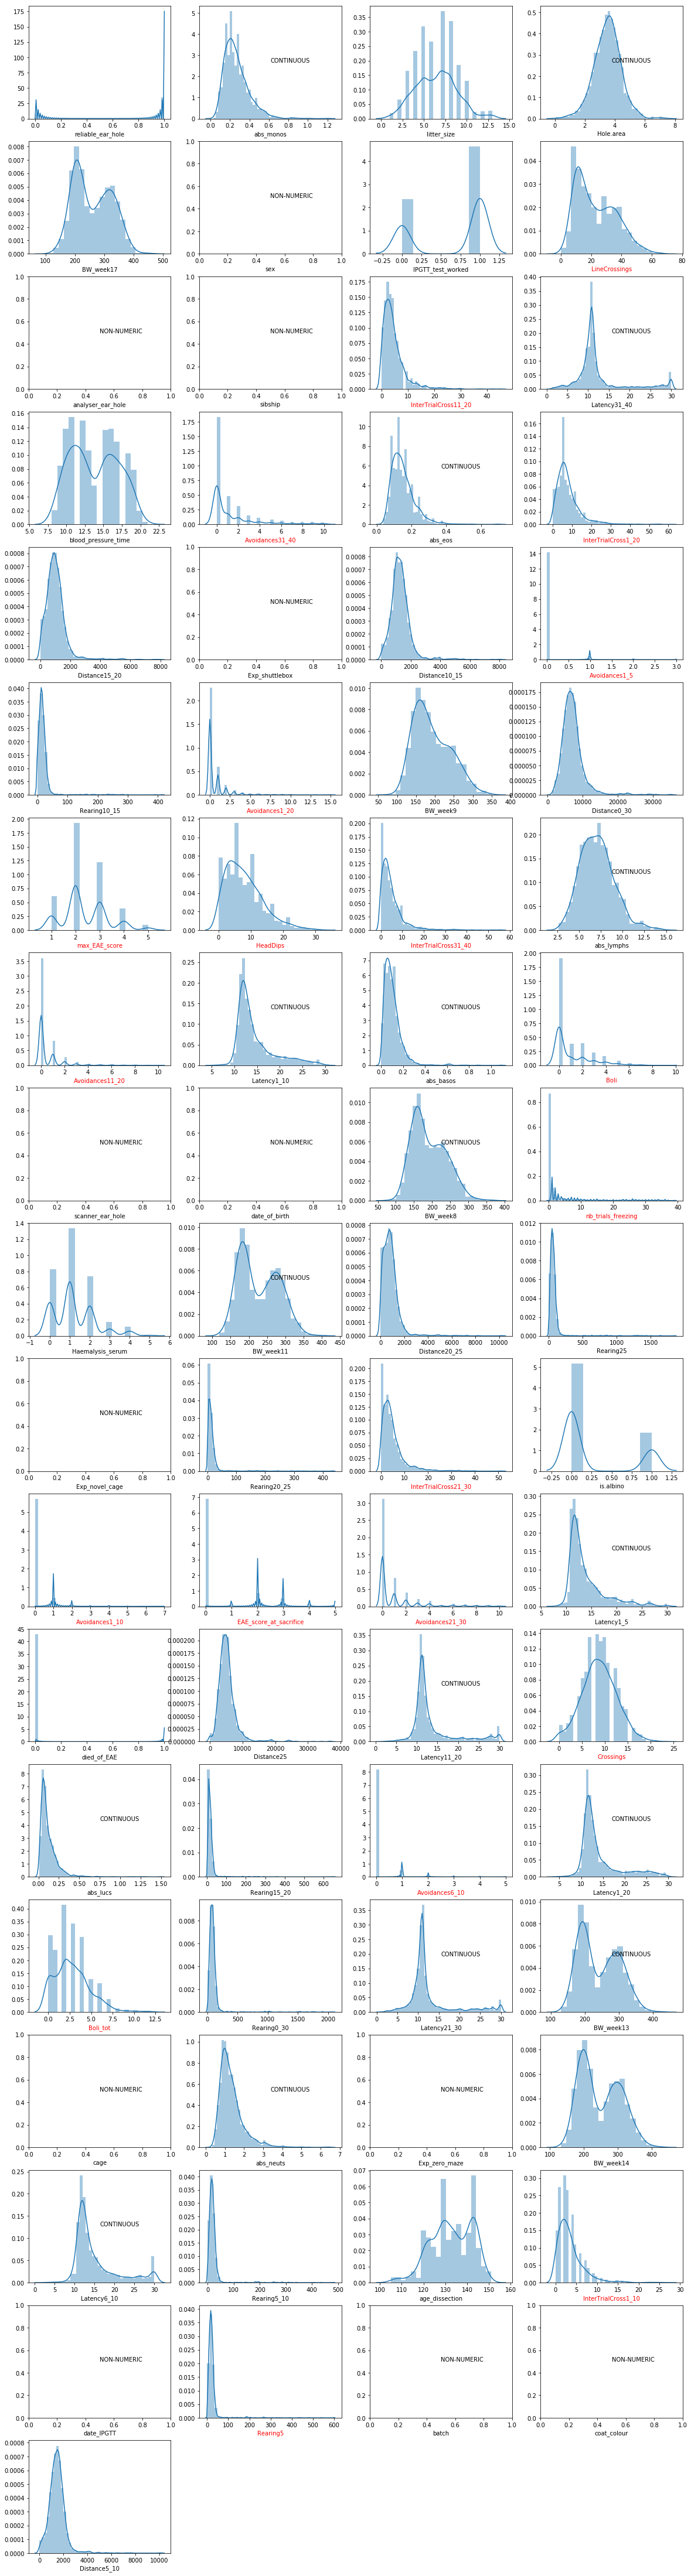

In [14]:
plot_distplots(df_notin_pheno, 80)

## 2.2 Traits that are considered normal in Hannah's analysis

In [15]:
pheno_normal.head()

,Distance25_30,Distance5,ALP,ALT,AST,Calcium,Chloride,Creatinine,Glucose,HDL,...,G0,G120,G30,G60,Latency1_40,time_freezing,LatencyOpenSection,PosturesClosedToOpen,TimeOpenSection,PltClumps
subject,,,,,,,,,,,,,,,,,,,,,
Outbred1,410.0,1529.0,159.0,61.7,123.8,2.51,97.0,30.1,12.92,1.11,...,6.2,5.9,7.8,6.8,14.18,297.0,NaN,7.0,NaN,89.0
Outbred10,756.0,1356.0,128.0,59.6,112.6,2.27,91.0,27.7,9.89,0.91,...,5.8,5.8,8.7,6.7,10.62,NaN,68.0,8.0,19.0,81.0
Outbred100,523.0,789.0,205.0,87.3,133.5,2.58,101.0,29.1,12.24,1.27,...,6.4,5.9,10.4,7.4,17.18,NaN,8.0,11.0,135.0,247.0
Outbred1000,2147.0,2801.0,269.0,53.8,126.7,2.65,102.0,31.9,8.58,1.16,...,5.3,5.4,7.2,6.0,11.24,273.0,14.0,9.0,143.0,49.0
Outbred1001,2359.0,3056.0,201.0,69.5,145.8,2.62,101.0,36.4,8.80,1.20,...,4.7,4.7,7.7,5.6,13.97,NaN,24.0,6.0,100.0,44.0


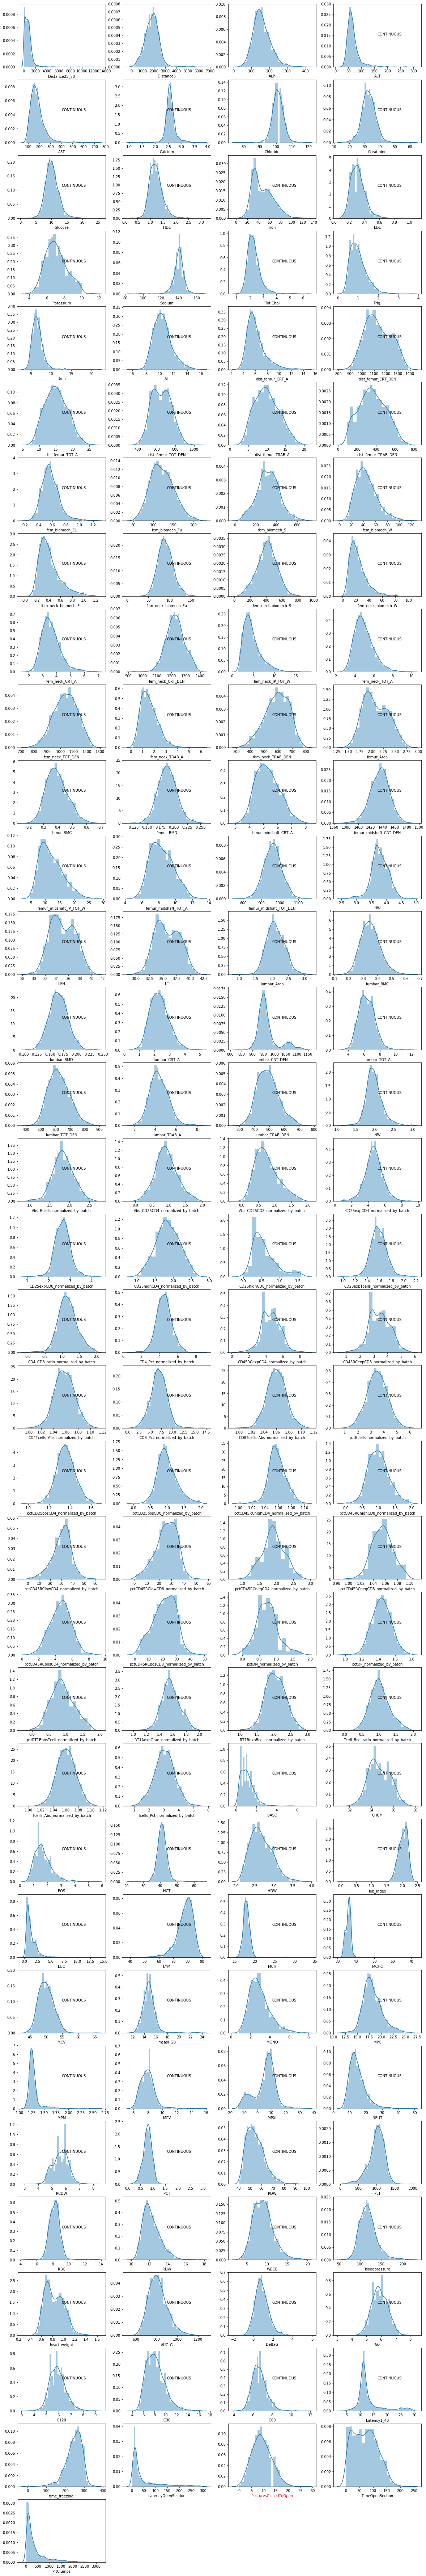

In [16]:
plot_distplots(pheno_normal, 130)

## 2.3 Traits that are NOT considered normal in Hannah's analysis

In [17]:
pheno_notNormal.head()

,Has1kidney,AA_IL_nb,AA_IL_score,AA_nb,AA_score,IL_nb,IL_score,Avoidances1_40,InterTrialCross1_40,EntriesOpenSection
subject,,,,,,,,,,
Outbred1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,7.0,0.0
Outbred10,0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,14.0,3.0
Outbred100,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.0,3.0
Outbred1000,0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,15.0,15.0
Outbred1001,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,10.0


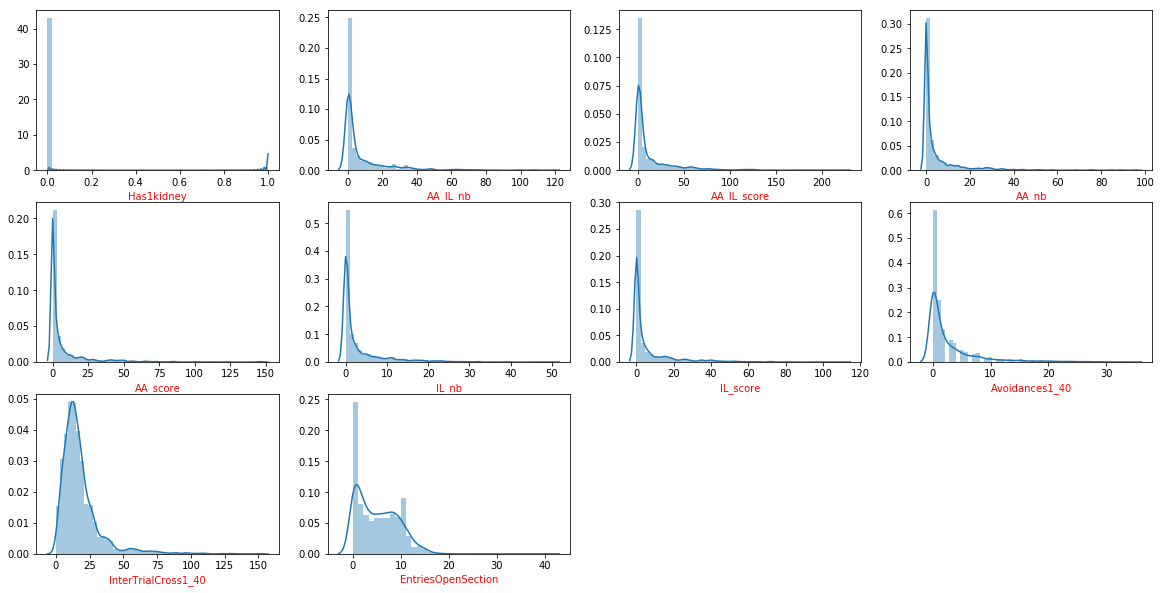

In [18]:
plot_distplots(pheno_notNormal, 10)

### 2.4 Covariates 

In [19]:
%%R -o covariates

covariates <- measures[, colnames(measures) %in%
                           c("BW_week11", "BW_week14", "BW_week17",
                              covariate_names$Measure) ]
covariates <- apply(covariates, 2, function(x) {
    if (! is.numeric(x)) return(as.numeric(as.factor(x)))
    if (is.numeric(x)) return(x)
})
rownames(covariates) <- measures$SUBJECT.NAME

# manually match covariate names from NatGenetc supp info to colnames of measure/
# covariates
#colnames(covariates)
#[1] "BW_week11"   "age_dissection"  "analyser_ear_hole"  "batch"
#[5] "blood_pressure_time"   "cage"  "date_IPGTT"   "date_of_birth"
#[9] "died_of_EAE"   "sibship"   "Haemalysis_serum"   "is.albino"
#[13] "litter_size"   "max_EAE_score"   "reliable_ear_hole"   "scanner_ear_hole"
#[17] "EAE_score_at_sacrifice" "sex"   "IPGTT_test_worked"   "BW_week14"
#[21] "BW_week17"   "Exp_novel_cage"   "Exp_zero_maze" "Exp_shuttlebox"

## information about conversion of these variables directly from from Amelie Baud
colnames(covariates)[colnames(covariates) == "BW_week11"] <- "BW_at_IPGTT"
colnames(covariates)[colnames(covariates) == "BW_week14"] <- "BW_at_day9_pi"
colnames(covariates)[colnames(covariates) == "BW_week17"] <- "BW_at_day28_pi"
colnames(covariates)[colnames(covariates) == "age_dissection"] <- "age"
colnames(covariates)[colnames(covariates) == "Haemalysis_serum"] <- "Haemalysis"
colnames(covariates)[colnames(covariates) == "IPGTT_test_worked"] <- "test_worked"

In [20]:
measure_renaming = dict()
measure_renaming["BW_week11"] = "BW_at_IPGTT"
measure_renaming["BW_week14"] = "BW_at_day9_pi"
measure_renaming["BW_week17"] = "BW_at_day28_pi"
measure_renaming["age_dissection"] = "age"
measure_renaming["Haemalysis_serum"] = "Haemalysis"
measure_renaming["IPGTT_test_worked"] = "test_worked"
measure_renaming.update({v: k for (k, v) in measure_renaming.items()})

### 2.5 Map covariates to phenotypes

In [21]:
%%R -o uniqueCovariatesTested -o relevantCovariates

root = config$root
directory <- paste(config$root, "processeddata", sep="/")

phenotype_names_N <- phenotype_names_N[phenotype_names_N$Measure %in%
                                       colnames(phenotypes_normal),]
phenotype_names_N <- phenotype_names_N[ match(colnames(phenotypes_normal),
                                       phenotype_names_N$Measure),]

phenotype2covs <- lapply(1:nrow(phenotype_names_N), function(x) {
    unlist(strsplit(phenotype_names_N$Covariates[x], ","))
})
names(phenotype2covs) <- phenotype_names_N$Measure
# saveRDS(phenotype2covs, paste(directory, "/phenotype2covs.rds", sep=""))

uniqueCovariatesTested <- unique(unlist(phenotype2covs))
#[1] "sex" "batch" "is.albino" "Haemalysis"
#[5] "BW_at_day28_pi" "BW_at_day9_pi" "age" "BW_at_IPGTT" "test_worked"
relevantCovariates <- covariates[,colnames(covariates) %in% uniqueCovariatesTested]
# write.table(relevantCovariates, paste(directory, "/covariates.csv", sep=""),
#             row.names=TRUE, col.names=NA, quote=FALSE, sep=",")

In [22]:
%%R -o phenotype2covs

phenotype2covs <- readRDS(paste(directory, "/phenotype2covs.rds", sep=""))

In [23]:
relevantCovariates = pd.read_csv(join(root, "processeddata", "covariates.csv"))
relevantCovariates = relevantCovariates.rename(columns={"Unnamed: 0": "subject"})
relevantCovariates = relevantCovariates.set_index("subject")
relevantCovariates.head()

,BW_at_IPGTT,age,batch,Haemalysis,is.albino,sex,test_worked,BW_at_day9_pi,BW_at_day28_pi
subject,,,,,,,,,
Outbred1,428.0,NaN,1,1.0,2,2,1,172.0,212.0
Outbred10,442.0,NaN,1,3.0,2,2,1,176.0,198.0
Outbred100,396.0,NaN,1,3.0,2,2,1,169.0,150.0
Outbred1000,415.0,14.0,5,1.0,2,2,1,159.0,193.0
Outbred1001,465.0,14.0,5,1.0,2,2,1,171.0,195.0


In [24]:
def rds2dict(x):
    y = dict()
    for i in range(len(x)):
        y[x.names[i]] = list(x[i])
    return y
phenotype2covs = rds2dict(phenotype2covs)

In [25]:
for v in relevantCovariates.columns.values:
    if v in list(measures.columns.values):
        print("{} covariate found in `measures`".format(v))
    else:
        if measure_renaming[v] in list(measures.columns.values):
            print("{} covariate found in `measures` after RENAMING".format(v))
        else:
            print("{} covariate NOT found in `measures`".format(v))

BW_at_IPGTT covariate found in `measures` after RENAMING
age covariate found in `measures` after RENAMING
batch covariate found in `measures`
Haemalysis covariate found in `measures` after RENAMING
is.albino covariate found in `measures`
sex covariate found in `measures`
test_worked covariate found in `measures` after RENAMING
BW_at_day9_pi covariate found in `measures` after RENAMING
BW_at_day28_pi covariate found in `measures` after RENAMING


In [26]:
for v in list(covariates.colnames):
    if v in list(measures.columns.values):
        print("{} covariate found in `measures`".format(v))
    else:
        if measure_renaming[v] in list(measures.columns.values):
            print("{} covariate found in `measures` after RENAMING".format(v))
        else:
            print("{} covariate NOT found in `measures`".format(v))

BW_at_IPGTT covariate found in `measures` after RENAMING
age covariate found in `measures` after RENAMING
analyser_ear_hole covariate found in `measures`
batch covariate found in `measures`
blood_pressure_time covariate found in `measures`
cage covariate found in `measures`
date_IPGTT covariate found in `measures`
date_of_birth covariate found in `measures`
died_of_EAE covariate found in `measures`
sibship covariate found in `measures`
Haemalysis covariate found in `measures` after RENAMING
is.albino covariate found in `measures`
litter_size covariate found in `measures`
max_EAE_score covariate found in `measures`
reliable_ear_hole covariate found in `measures`
scanner_ear_hole covariate found in `measures`
EAE_score_at_sacrifice covariate found in `measures`
sex covariate found in `measures`
test_worked covariate found in `measures` after RENAMING
BW_at_day9_pi covariate found in `measures` after RENAMING
BW_at_day28_pi covariate found in `measures` after RENAMING
Exp_novel_cage covar

In [27]:
covariates0 = covariates
covariates = pd.DataFrame(np.asarray(covariates0))
covariates.columns = list(covariates0.colnames)
covariates["subject"] = list(covariates0.rownames)
covariates = covariates.set_index("subject")

### 2.6 Summary of the variables

In [28]:
print("measures:             {} # collection of all measurements".format(measures.shape))
print("phenotype2covs:       {}         # mapping from trait to covariates".format(len(phenotype2covs)))
print("pheno_NatGenet:       {}    # metainfo about traits from Baud et al (2013)".format(pheno_NatGenet.shape))
print("pheno_ScientificData: {}    # metainfo about traits from Baud et al (2014)".format(pheno_ScientificData.shape))
print("pheno_normal:         {} # normal traits from Hannah".format(pheno_normal.shape))
print("pheno_notNormal:      {}  # notNormal traits from Hannah".format(pheno_notNormal.shape))
print("df_notin_pheno:       {}  # measurements not found in pheno_cols".format(df_notin_pheno.shape))
print("covariates:           {}  # covariates from Hannah".format(covariates.shape))
print("relevantCovariates:   {}   # relevant covariates from Hannah".format(relevantCovariates.shape))
print("measure_renaming:     {}          # bidirectional mapping of Hannah's measurement renaming".format(len(measure_renaming)))

measures:             (2006, 216) # collection of all measurements
phenotype2covs:       133         # mapping from trait to covariates
pheno_NatGenet:       (160, 8)    # metainfo about traits from Baud et al (2013)
pheno_ScientificData: (216, 6)    # metainfo about traits from Baud et al (2014)
pheno_normal:         (2006, 133) # normal traits from Hannah
pheno_notNormal:      (2006, 10)  # notNormal traits from Hannah
df_notin_pheno:       (2006, 73)  # measurements not found in pheno_cols
covariates:           (2006, 24)  # covariates from Hannah
relevantCovariates:   (2006, 9)   # relevant covariates from Hannah
measure_renaming:     12          # bidirectional mapping of Hannah's measurement renaming


# 3 Imputation

In [29]:
%%R -o kinship -o common_samples

## directories ####
rawdir <- paste(root, "/rawdata/arrayexpress", sep="")
directory <- paste(root, "/processeddata", sep="")

## data ####
phenotypes_normal <- read.table(paste(directory, "/phenotypes_normal.csv",
                                      sep=""),
                            header=TRUE, row.names=1, stringsAsFactors=FALSE,
                            sep=",")

covariates <- read.table(paste(directory, "/covariates.csv", sep=""),
                         header=TRUE, row.names=1, stringsAsFactors=FALSE,
                         sep=",")

kinship <- read.table(paste(rawdir, "/HS_rats_kinship_norm.csv", sep=""),
                      header=TRUE, stringsAsFactors=FALSE,
                      sep=",")
                      
common_samples <- colnames(kinship)[colnames(kinship) %in% rownames(phenotypes_normal)]

kinship <- kinship[colnames(kinship) %in% common_samples, colnames(kinship) %in% common_samples]

phenotypes_normal <- phenotypes_normal[rownames(phenotypes_normal) %in% common_samples,]
phenotypes_normal <- phenotypes_normal[match(colnames(kinship), rownames(phenotypes_normal)),]

covariates <- covariates[rownames(covariates) %in% common_samples,]
covariates <- covariates[match(colnames(kinship), rownames(covariates)),]

# for imputation purposes, combine covariate and phenotype data
combined_all <- cbind(covariates, phenotypes_normal)

## general parameters ####
cutoff <- 0.95
col <- c('#fc8d62','#8da0cb')
text_size <- 12

/usr/local/anaconda3/envs/rats/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [30]:
kinship.columns.values

array(['Outbred10', 'Outbred100', 'Outbred1000', ..., 'Outbred994',
       'Outbred995', 'Outbred999'], dtype=object)

In [31]:
kinship.index = kinship.columns.values.copy()

In [32]:
kinship.head()

,Outbred10,Outbred100,Outbred1000,Outbred1001,Outbred1002,Outbred1003,Outbred1006,Outbred1007,Outbred1008,Outbred1009,...,Outbred987,Outbred988,Outbred989,Outbred990,Outbred991,Outbred992,Outbred993,Outbred994,Outbred995,Outbred999
Outbred10,6.009824,4.657918,5.479625,5.418838,5.404296,5.439283,5.226009,5.008503,4.948340,4.981719,...,4.980516,4.963946,4.894734,4.914590,4.949563,4.680058,4.830228,4.834785,4.789685,5.383430
Outbred100,4.657918,5.737956,4.764362,4.701020,4.709254,4.748388,4.813588,4.911552,4.841216,4.883429,...,4.865227,4.862593,4.794374,4.816218,4.885404,4.630496,4.834140,4.868218,4.862943,4.754280
Outbred1000,5.479625,4.764362,6.200240,5.806138,5.747500,5.778229,5.349606,5.087776,5.012144,5.071292,...,5.021771,5.056555,4.964942,4.964675,5.057984,4.802489,4.999009,5.008811,4.949830,5.867601
Outbred1001,5.418838,4.701020,5.806138,6.125864,5.861705,5.813432,5.328939,5.073914,4.984344,5.050553,...,4.973953,4.967413,4.921145,4.901156,4.981035,4.752995,4.962390,4.960466,4.915544,5.767700
Outbred1002,5.404296,4.709254,5.747500,5.861705,6.186393,5.757447,5.352778,5.080052,5.012185,5.100002,...,4.944851,4.981080,4.901690,4.904372,4.987777,4.702598,4.895629,4.898984,4.862922,5.820061


In [33]:
K = xarray.DataArray(kinship.copy()).rename({"dim_0": "subject_0", "dim_1": "subject_1"})

## 3.1 Pattern of missing data

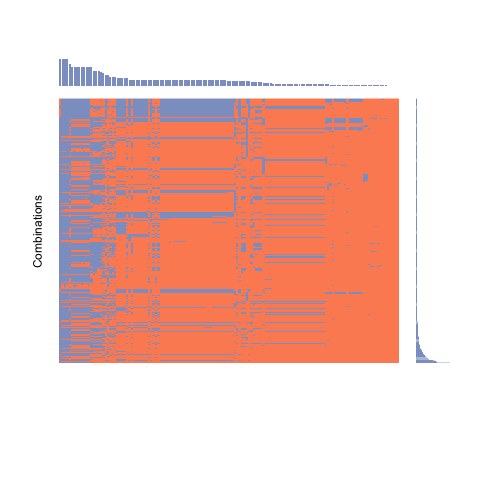

In [34]:
%%R -o kinship

## a) distribution
plot_pattern_missingness(combined_all, directory=directory,
                         name="missing_data_pattern_allTraits")

frequency_missingness <- data.frame(missing=
                         apply(combined_all, 2, function(x)
                                  length(which(is.na(x)))/length(x)))
frequency_missingness$complete <- 1 - frequency_missingness$missing

Traits2Keep <- frequency_missingness$missing <= 0.20
combined_filterTraits <- combined_all[, Traits2Keep]

per_sample_missingness <- data.frame(missing=
     apply(combined_filterTraits, 1, function(x)
        length(which(is.na(x)))/length(x)))

per_sample_missingness$complete <- 1 - per_sample_missingness$missing

Samples2Keep <- per_sample_missingness$missing <= 0.20
kinship <- kinship[Samples2Keep, Samples2Keep]
combined <- combined_filterTraits[Samples2Keep,]

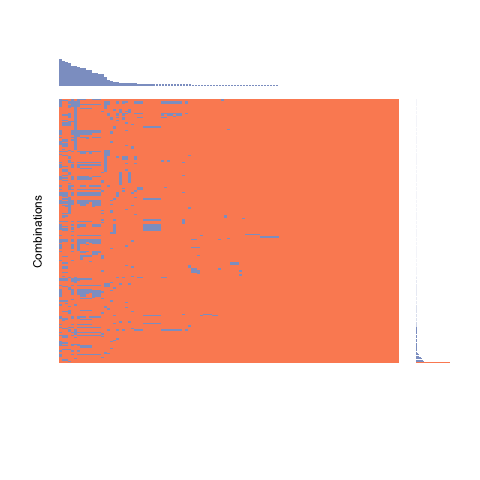

In [35]:
%%R

plot_pattern_missingness(combined, directory=directory, name="missing_data_pattern_filteredTraits")

## 3.2 Missing data mechanism

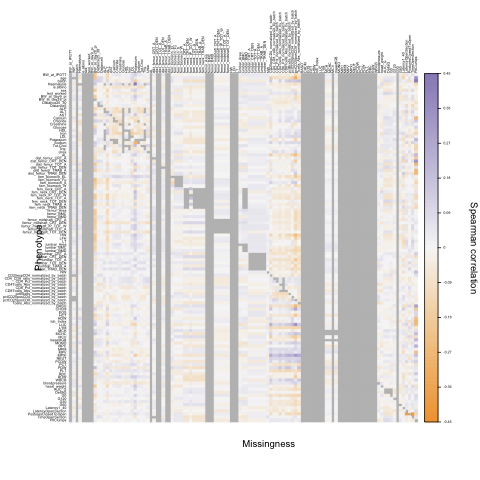

In [36]:
%%R

### MAR
corrMiss <- correlationMissingness(combined)
plot_correlation_missingness(data=corrMiss, savePdf=FALSE,
                             directory=directory, labelsize=0.3)

## 3.3 Dataset with no missing values

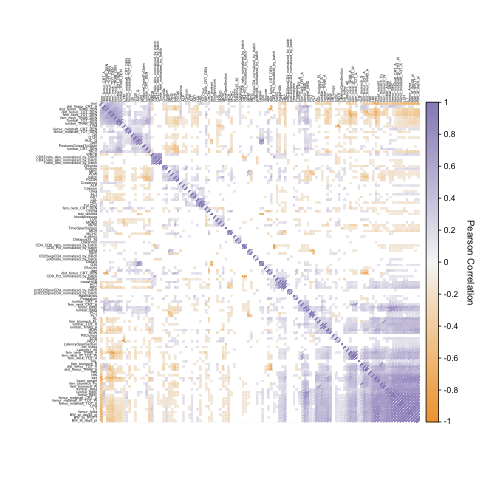

In [37]:
%%R

combined_noNA <- fullPhenotypes(combined)

## a) correlation between phenotypes
corrPhenotypes <- correlationPhenotypes(combined)

plot_correlation_phenotypes(data_r=corrPhenotypes$r,
                            data_p=corrPhenotypes$padjust, savePdf=FALSE,
                            directory=directory, labelsize=0.3)

## 3.4 Generate dataset with artificial missingness

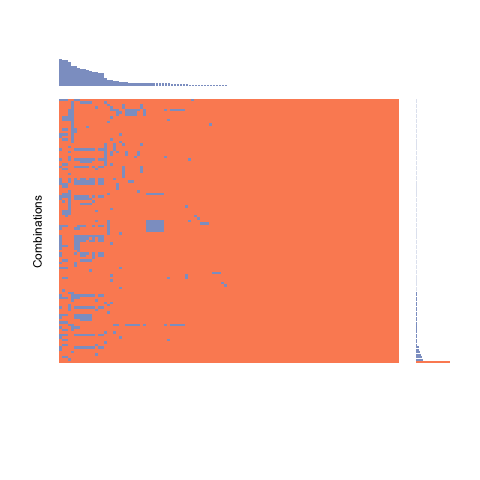

In [38]:
%%R

combined_artificial <- artificialMissingness(data=combined, fulldata=combined_noNA,
                                             kinship=kinship, seed=3422)

plot_pattern_missingness(combined_artificial$data_addNA, directory=directory,
                         name="missing_data_pattern_simulated", savePdf=FALSE)

## 3.5 Impute artifically created missing data

In [39]:
%%R

imputed <- imputeData(data=as.matrix(combined_artificial$data_addNA),
                      fulldata=combined_noNA,
                      kinship=combined_artificial$kinship,
                      method=c("phenix", "mvn", "mice"),
                      cutoff=cutoff, testing=TRUE)
#> Warning in sqrt(1 - h * h): NaNs produced

#> Warning in sqrt(1 - h * h): NaNs produced
#> Using pheno as id variables
knitr::kable(imputed$summary,
    caption="\\label{tab:imputation}Correlation of imputed vs real phenotype values")

/usr/local/anaconda3/envs/rats/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Using pheno as id variables

  warnings.warn(x, RRuntimeWarning)




|         | median|      mean|        sd|
|:--------|------:|---------:|---------:|
|mice_0.1 |      1| 0.9900470| 0.0237503|
|mice_0.2 |      1| 0.9895366| 0.0237503|
|mice_0.3 |      1| 0.9860840| 0.0355147|
|mice_All |      1| 0.9901822| 0.0241120|
|mvn      |      1| 0.9905609| 0.0228132|
|phenix   |      1| 0.9910931| 0.0221556|


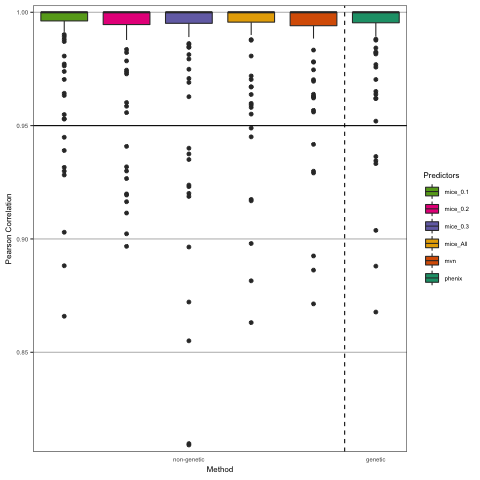

In [40]:
%%R

plot_overview_correlation_imputation(imputed$cor, savePdf=FALSE, directory=directory,
                                     text_size=6)

In [41]:
%%R

corr_plots_methods <- plot_individual_correlation_imputation(imputed$cor,
                                                             savePdf=FALSE,
                        directory=directory, text_size=6)

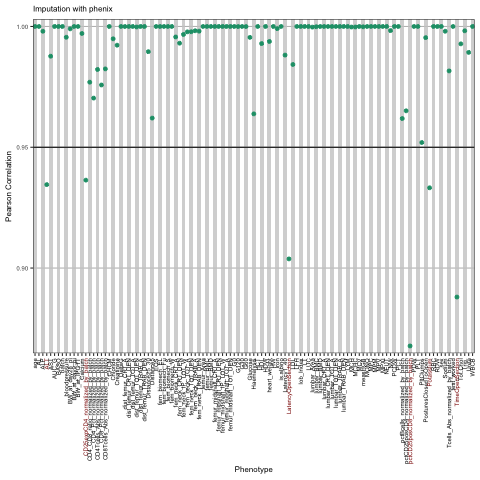

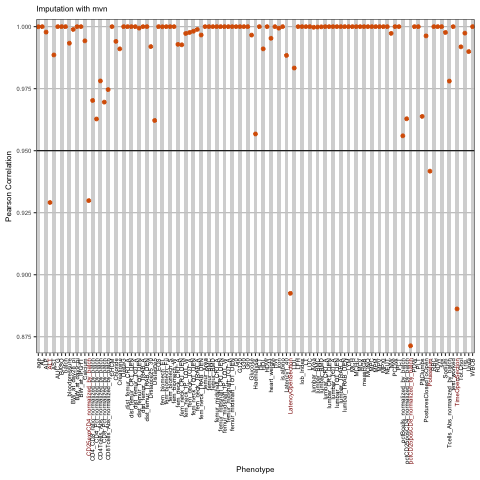

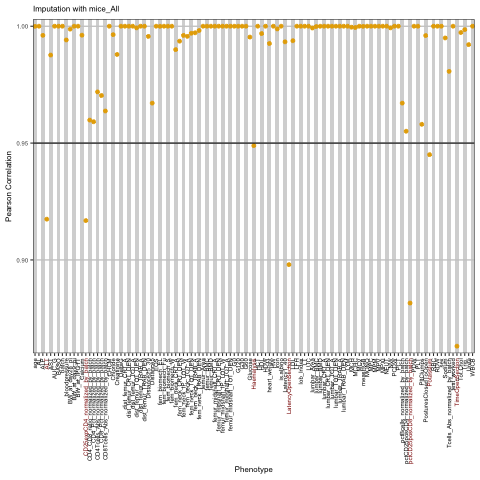

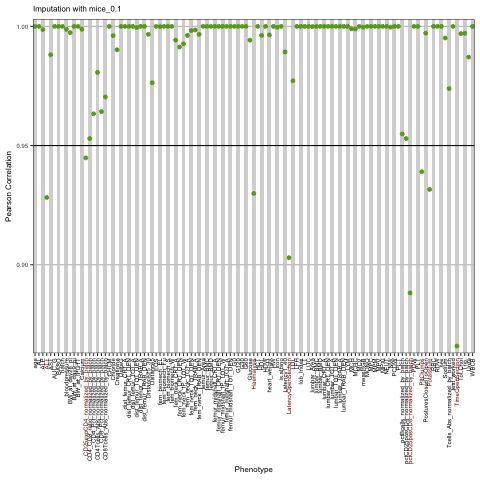

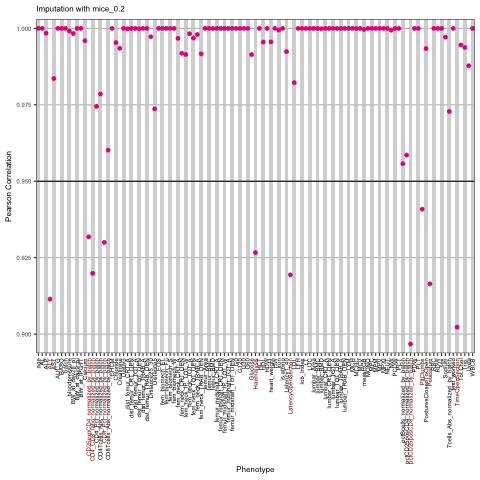

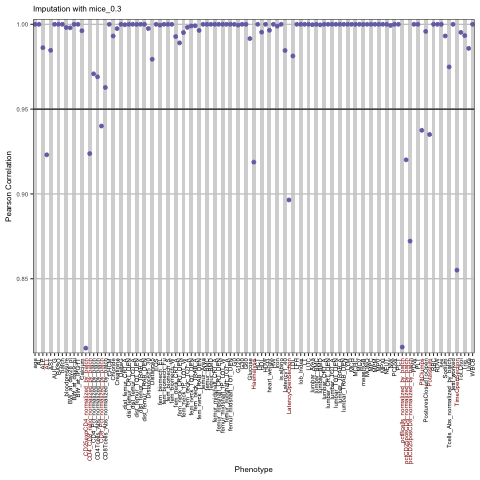

In [42]:
%%R

dummy <- lapply(corr_plots_methods, function(p) print(p))

## 3.6 Impute full data set

In [ ]:
%%R

imputable <-  data.frame(sapply(c("phenix", "mvn", "mice"), imputableTraits, 
                                  imputed, cutoff))

imputed_phenos <- imputeData(data=combined, methods= c("phenix", "mice", "mvn"), 
                       imputable=imputable, cutoff=0.95, testing=FALSE, 
                       kinship=as.matrix(kinship))
saveRDS(imputed_phenos, paste(directory, "/imputed_phenotypes.rds", sep=""))

In [ ]:
%%R

phenotype2covs <- readRDS(paste(directory, "/phenotype2covs.rds", sep=""))

regress <- function(trait, pheno, cov, pheno2cov ) {
    which.cov <- which(colnames(cov) %in% pheno2cov[[trait]])
    summary(lm(pheno[,colnames(pheno) == trait] ~ cov[,which.cov]))$residuals
}

combined_phenix <- imputed_phenos$imp$phenix$imp
pheno_phenix <- combined_phenix[, which(colnames(combined_phenix) %in% colnames(phenotypes_normal))]
cov_phenix <- combined_phenix[, which(colnames(combined_phenix) %in% colnames(covariates))]
phenix_reg <- sapply(colnames(pheno_phenix), regress, pheno=pheno_phenix, 
                    cov=cov_phenix, pheno2cov=phenotype2covs)

write.table(phenix_reg, paste(directory, "/phenotypes_phenix_reg.csv", sep=""), 
            sep=",", col.names=NA, row.names=TRUE, quote=FALSE)

combined_mvn <- imputed_phenos$imp$mvn$imp
pheno_mvn <- combined_mvn[, which(colnames(combined_mvn) %in% colnames(phenotypes_normal))]
cov_mvn <- combined_mvn[, which(colnames(combined_mvn) %in% colnames(covariates))]
mvn_reg <- sapply(colnames(pheno_mvn), regress, pheno=pheno_mvn, 
                    cov=cov_mvn, pheno2cov=phenotype2covs)

write.table(mvn_reg, paste(directory, "/phenotypes_mvn_reg.csv", sep=""), 
            sep=",", col.names=NA, row.names=TRUE, quote=FALSE)


combined_mice<- imputed_phenos$imp$mice$imp
pheno_mice <- combined_mice[, which(colnames(combined_mice) %in% colnames(phenotypes_normal))]
cov_mice <- combined_mice[, which(colnames(combined_mice) %in% colnames(covariates))]
mice_reg <- sapply(colnames(pheno_mice), regress, pheno=pheno_mice, 
                    cov=cov_mice, pheno2cov=phenotype2covs)

write.table(mice_reg, paste(directory, "/phenotypes_mice_reg.csv", sep=""), 
            sep=",", col.names=NA, row.names=TRUE, quote=FALSE)

In [ ]:
%%R

commonImputable <- intersect(intersect(colnames(mice_reg), colnames(mvn_reg)), 
                             colnames(phenix_reg))

mice_mvn <- do.call(rbind, lapply(commonImputable, function(x) {
    tmp <- Hmisc::rcorr(mice_reg[,colnames(mice_reg) == x], 
                        mvn_reg[,colnames(mvn_reg) == x])
    return(data.frame(p=tmp$P[1,2], r2=tmp$r[1,2], comparison="mice_mvn", trait=x))
}))

mice_phenix <- do.call(rbind, lapply(commonImputable, function(x) {
    tmp <- Hmisc::rcorr(mice_reg[,colnames(mice_reg) == x], 
                        phenix_reg[,colnames(phenix_reg) == x])
    return(data.frame(p=tmp$P[1,2], r2=tmp$r[1,2], comparison="mice_phenix", trait=x))
}))

phenix_mvn <- do.call(rbind, lapply(commonImputable, function(x) {
    tmp <- Hmisc::rcorr(phenix_reg[,colnames(phenix_reg) == x], 
                        mvn_reg[,colnames(mvn_reg) == x])
    return(data.frame(p=tmp$P[1,2], r2=tmp$r[1,2],comparison="mvn_phenix", trait=x))
}))

compare_corr <- rbind(mice_mvn, mice_phenix, phenix_mvn)
compare_corr$comparison <- as.factor(compare_corr$comparison)

p <- ggplot2::ggplot(data=compare_corr, ggplot2::aes(x=comparison, y=r2, 
                                   color=comparison))
p + ggplot2::geom_boxplot(outlier.colour = NA) + 
    ggplot2::geom_label(data=dplyr::filter(compare_corr, r2 < 0.95), ggplot2::aes(y=r2, 
                                                                x=comparison,
                                                                label=trait),
               nudge_y = -0.002, size=3) +
    ggplot2::geom_jitter(width = 0.2) +
    ggplot2::scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3'), guide=FALSE) +
    ylab("Pearson Correlation") +
    ggplot2::theme_bw()

In [46]:
folder = join(root, "processeddata")
ipheno = join(folder, "imputed_phenotypes.rds")
readRDS = robjects.r["readRDS"]
df = readRDS(ipheno)
# $imp$phenix$imp
m = pandas2ri.ri2py(df[0][0][0])
ipheno = pd.DataFrame(
    data=m, columns=list(df[0][0][0].colnames), index=list(df[0][0][0].rownames)
)
print(ipheno.head())

             BW_at_IPGTT   age  batch  Haemalysis  is.albino  sex  \
Outbred1000        415.0  14.0    5.0         1.0        2.0  2.0   
Outbred1001        465.0  14.0    5.0         1.0        2.0  2.0   
Outbred1002        415.0  14.0    5.0         1.0        2.0  2.0   
Outbred1003        376.0  14.0    5.0         1.0        2.0  2.0   
Outbred1006        257.0  17.0    5.0         1.0        1.0  2.0   

             test_worked  BW_at_day9_pi  BW_at_day28_pi  Distance25_30  \
Outbred1000          1.0          159.0           193.0         2147.0   
Outbred1001          1.0          171.0           195.0         2359.0   
Outbred1002          1.0          160.0           180.0          896.0   
Outbred1003          1.0          155.0           181.0          910.0   
Outbred1006          2.0           96.0           119.0          727.0   

               ...      heart_weight  AUC_G  DeltaG   G0  G120  G30  G60  \
Outbred1000    ...            1.0740  727.5  0.7625  5.3   5.4  

In [63]:
common_samples = list(common_samples)

In [67]:
print("measures:             {}  # collection of all measurements".format(measures.shape))
print("phenotype2covs:       {}          # mapping from trait to covariates".format(len(phenotype2covs)))
print("pheno_NatGenet:       {}     # metainfo about traits from Baud et al (2013)".format(pheno_NatGenet.shape))
print("pheno_ScientificData: {}     # metainfo about traits from Baud et al (2014)".format(pheno_ScientificData.shape))
print("pheno_normal:         {}  # normal traits from Hannah".format(pheno_normal.shape))
print("pheno_notNormal:      {}   # notNormal traits from Hannah".format(pheno_notNormal.shape))
print("df_notin_pheno:       {}   # measurements not found in pheno_cols".format(df_notin_pheno.shape))
print("covariates:           {}   # covariates from Hannah".format(covariates.shape))
print("relevantCovariates:   {}    # relevant covariates from Hannah".format(relevantCovariates.shape))
print("measure_renaming:     {}           # bidirectional mapping of Hannah's measurement renaming".format(len(measure_renaming)))
print("kinship:              {} # kinship".format(kinship.shape))
print("common_samples        {}         # common samples between traits data and kinship".format(len(common_samples)))
print("ipheno:               {}  # imputed traits from Hannah".format(ipheno.shape))

measures:             (2006, 216)  # collection of all measurements
phenotype2covs:       133          # mapping from trait to covariates
pheno_NatGenet:       (160, 8)     # metainfo about traits from Baud et al (2013)
pheno_ScientificData: (216, 6)     # metainfo about traits from Baud et al (2014)
pheno_normal:         (2006, 133)  # normal traits from Hannah
pheno_notNormal:      (2006, 10)   # notNormal traits from Hannah
df_notin_pheno:       (2006, 73)   # measurements not found in pheno_cols
covariates:           (2006, 24)   # covariates from Hannah
relevantCovariates:   (2006, 9)    # relevant covariates from Hannah
measure_renaming:     12           # bidirectional mapping of Hannah's measurement renaming
kinship:              (1407, 1407) # kinship
common_samples        1407         # common samples between traits data and kinship
ipheno:               (1096, 107)  # imputed traits from Hannah


1407

In [ ]:
 -o common_samples

In [ ]:
rawdata/phenotypes_mice_reg.csv
rawdata/phenotypes_mvn_reg.csv
rawdata/phenotypes_phenix_reg.csv
rawdata/phenotype2covs.rds